## **Objective**  
In this episode we are given the task of predicting the rainfall for each day of the year. 
Submissions are evaluated on the **Area Under the Receiver Operating Characteristic Curve** between the predicted probability and the observed target.

**AUC-ROC** is defined as:

$$
\textrm{AUC} = \sum_{i=1}^{n} ( \textrm{FPR}_i - \textrm{FPR}_{i-1} ) \times \textrm{TPR}_i
$$
 
## **Data**  
The dataset for this competition is generated from a deep learning model trained on the [Rainfall Prediction using Machine Learning](https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns




sns.set_theme(style="whitegrid", palette="muted")

print('Libaires imported')

Libaires imported


In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')
original_data = pd.read_csv('/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv')

print('Data imported')

Data imported


In [3]:
train_data

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


In [4]:
test_data

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4
...,...,...,...,...,...,...,...,...,...,...,...,...
725,2915,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3
726,2916,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2
727,2917,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9
728,2918,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5


In [5]:
original_data

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...
361,27,1022.7,18.8,17.7,16.9,15.0,84,90,yes,0.0,30.0,18.4
362,28,1026.6,18.6,17.3,16.3,12.8,75,85,yes,1.0,20.0,25.9
363,29,1025.9,18.9,17.7,16.4,13.3,75,78,yes,4.6,70.0,33.4
364,30,1025.3,19.2,17.3,15.2,13.3,78,86,yes,1.2,20.0,20.9


In [6]:
#Removing unweanted whitespace in column names

train_data.columns = train_data.columns.str.strip()
test_data.coloumns = test_data.columns.str.strip()
original_data.columns = original_data.columns.str.strip()

# Correct spelling inconsistency in train_data
train_data = train_data.rename(columns={'temparature': 'temperature'})
test_data = test_data.rename(columns={'temparature': 'temperature'})
original_data = original_data.rename(columns={'temparature': 'temperature'})

In [7]:
#Converting original dataset 'rainfall' column to binary format

original_data['rainfall'] = original_data['rainfall'].map({'yes':1, 'no':0})

In [8]:
train_duplicates = train_data.duplicated().sum()
test_duplicates = test_data.duplicated().sum()
original_duplicates = original_data.duplicated().sum()

print(f'Number of duplicate rows in train_data: {train_duplicates}')
print(f'Number of duplicate rows in test_data: {test_duplicates}')
print(f'Number of duplicate rows in original_data: {original_duplicates}')

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in original_data: 0


In [9]:
#Missing and unique values

missing_values_train = pd.DataFrame({'Feature': train_data.columns,
                                     '[TRAIN] Missing Values': train_data.isnull().sum().values})

missing_values_test = pd.DataFrame({'Feature': test_data.columns,
                                     '[TEST] Missing Values': test_data.isnull().sum().values})

missing_values_original = pd.DataFrame({'Feature': original_data.columns,
                                       '[ORIGINAL] Missing Values': original_data.isnull().sum().values})

unique_values_train = pd.DataFrame({'Feature': train_data.columns,
                              '[TRAIN] Unique Values': train_data.nunique().values})

unique_values_test = pd.DataFrame({'Feature': test_data.columns,
                              '[TEST] Unique Values': test_data.nunique().values})

unique_values_original = pd.DataFrame({'Feature': original_data.columns,
                              '[ORIGINAL] Unique Values': original_data.nunique().values})


feature_types = pd.DataFrame({'Feature': train_data.columns,
                              '[TRAIN] DataType': train_data.dtypes})

merged_df = pd.merge(missing_values_train, missing_values_test, on='Feature', how='left')
merged_df = pd.merge(merged_df, missing_values_original, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values_train, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values_test, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values_original, on='Feature', how='left')
merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

merged_df

,Feature,[TRAIN] Missing Values,[TEST] Missing Values,[ORIGINAL] Missing Values,[TRAIN] Unique Values,[TEST] Unique Values,[ORIGINAL] Unique Values,[TRAIN] DataType
0,id,0,0.0,NaN,2190,730.0,NaN,int64
1,day,0,0.0,0.0,365,365.0,31.0,int64
2,pressure,0,0.0,0.0,236,185.0,188.0,float64
3,maxtemp,0,0.0,0.0,219,182.0,174.0,float64
4,temperature,0,0.0,0.0,198,175.0,158.0,float64
5,mintemp,0,0.0,0.0,199,171.0,157.0,float64
6,dewpoint,0,0.0,0.0,218,172.0,158.0,float64
7,humidity,0,0.0,0.0,49,42.0,49.0,float64
8,cloud,0,0.0,0.0,78,69.0,79.0,float64
9,sunshine,0,0.0,0.0,120,110.0,104.0,float64


In [10]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2190.0,1094.500000,632.342866,0.0,547.250,1094.50,1641.750,2189.0
day,2190.0,179.948402,105.203592,1.0,89.000,178.50,270.000,365.0
pressure,2190.0,1013.602146,5.655366,999.0,1008.600,1013.00,1017.775,1034.6
maxtemp,2190.0,26.365799,5.654330,10.4,21.300,27.80,31.200,36.0
temperature,2190.0,23.953059,5.222410,7.4,19.300,25.50,28.400,31.5
mintemp,2190.0,22.170091,5.059120,4.0,17.700,23.85,26.400,29.8
dewpoint,2190.0,20.454566,5.288406,-0.3,16.800,22.15,25.000,26.7
humidity,2190.0,82.036530,7.800654,39.0,77.000,82.00,88.000,98.0
cloud,2190.0,75.721918,18.026498,2.0,69.000,83.00,88.000,100.0
sunshine,2190.0,3.744429,3.626327,0.0,0.400,2.40,6.800,12.1


In [11]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,730.0,2554.500000,210.877136,2190.0,2372.250,2554.50,2736.750,2919.0
day,730.0,183.000000,105.438271,1.0,92.000,183.00,274.000,365.0
pressure,730.0,1013.503014,5.505871,1000.0,1008.725,1012.70,1017.600,1032.2
maxtemp,730.0,26.372466,5.672521,7.4,21.600,27.80,31.000,35.8
temperature,730.0,23.963288,5.278098,5.9,19.825,25.65,28.375,31.8
mintemp,730.0,22.110274,5.170744,4.2,17.825,23.90,26.400,29.1
dewpoint,730.0,20.460137,5.391169,-0.0,16.800,22.30,25.000,26.7
humidity,730.0,82.669863,7.818714,39.0,77.250,82.00,89.000,98.0
cloud,730.0,76.360274,17.934121,0.0,69.000,83.00,88.000,100.0
sunshine,730.0,3.664384,3.639272,0.0,0.325,2.20,6.675,11.8


In [12]:
original_data.describe().T

,count,mean,std,min,25%,50%,75%,max
day,366.0,15.756831,8.823592,1.0,8.000,16.00,23.000,31.0
pressure,366.0,1013.742623,6.414776,998.5,1008.500,1013.00,1018.100,1034.6
maxtemp,366.0,26.191257,5.978343,7.1,21.200,27.75,31.200,36.3
temperature,366.0,23.747268,5.632813,4.9,18.825,25.45,28.600,32.4
mintemp,366.0,21.894536,5.594153,3.1,17.125,23.70,26.575,30.0
dewpoint,366.0,19.989071,5.997021,-0.4,16.125,21.95,25.000,26.7
humidity,366.0,80.177596,10.062470,36.0,75.000,80.50,87.000,98.0
cloud,366.0,71.128415,21.798012,0.0,58.000,80.00,88.000,100.0
rainfall,366.0,0.680328,0.466988,0.0,0.000,1.00,1.000,1.0
sunshine,366.0,4.419399,3.934398,0.0,0.500,3.50,8.200,12.1


## **Data Observations**

**Dataset Shape**  
- **Training Data:** 2190 rows × 13 columns.  
- **Test Data:** 730 rows × 12 columns.  
- **Original Data:** 366 rows × 12 columns.  
- **Duplicates:** None.

**Missing Values and Spelling Inconsistencies**  
- No missing values in the training dataset.  
- One missing value in the winddirection feature in the test dataset
- Two missing values in the winddirection and windspeen features in the original dataset.  
- Inconsistent spelling of temperature.

**Key Observations on All Datasets**  
- **ID:** A unique identifier for each record.  
- **Day:** Represents the day of the year (1 to 365). The original dataset has 366 total values but only 31 uniue values.  
- **Pressure:** Ranges from 998.5 to 1034.6 hPa.  
- **Temperature Features:** Max temp (7.1°C - 36.3°C), Min temp (3.1°C - 30.0°C), and Average temp.  
- **Dew Point:** Ranges from -0.0°C to 26.7°C.  
- **Humidity:** Ranges from 36% to 98%.  
- **Cloud Cover:** Ranges from 0% to 100%.  
- **Sunshine Duration:** Ranges from 0 to 12.1 hours.  
- **Wind Speed:** Ranges from 4.4 km/h to 59.5 km/h.  
- **Wind Direction:** Categorical, with 35 unique values.  
- **Rainfall:** Binary target variable (0 = No Rain, 1 = Rain).  

**Key Takeaways**
- The original dataset has a count of 366 and only 31 unique values for days. This could reflect month and days in a year and possibly a leap year. Proper alignment of days will be important if this dataset is used in the model.  
- High variance in cloud cover and humidity suggests their importance in predicting rainfall.  
- Rainfall distribution is imbalanced (~75% rainy days), which should be considered in modeling.
- Numerical weather data variables tend to need scaling to account for the differences in magnitude across different feastures.



## **EDA**

## **Training Data Heatmaps**

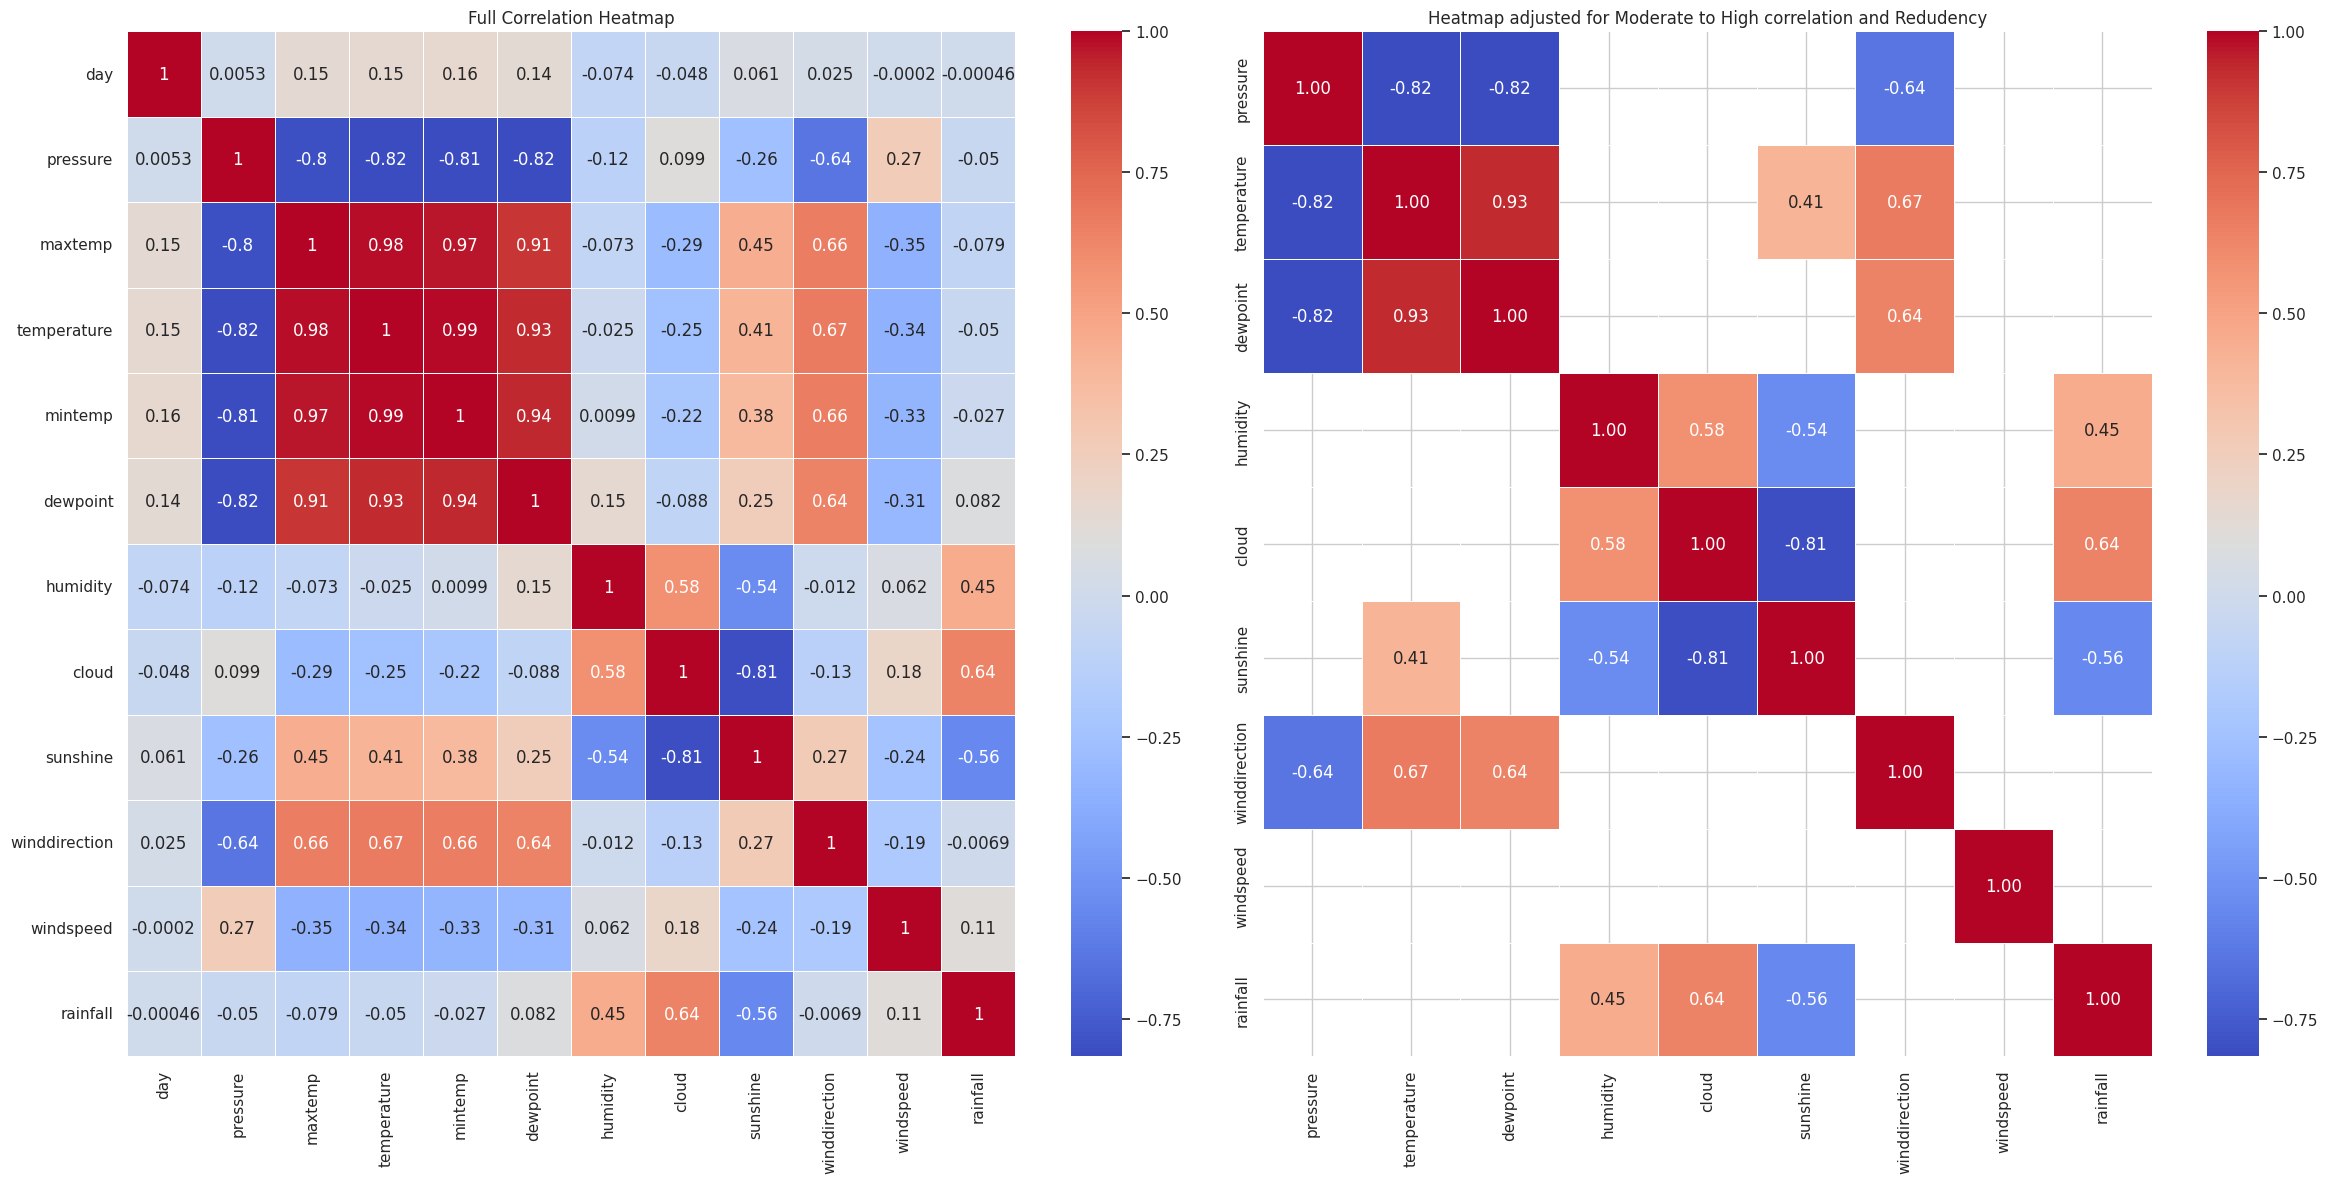

In [13]:
filtered_data = train_data.drop(columns=["maxtemp", "mintemp", "id", "day"])

full_corr_matrix = train_data.drop(columns=['id']).corr()
filtered_corr_matrix = filtered_data.corr()

mask = np.abs(filtered_corr_matrix) > 0.4

fig, axes = plt.subplots(1, 2, figsize=(24,12))

#Full correlation heatmap

sns.heatmap(full_corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, ax=axes[0])
axes[0].set_title('Full Correlation Heatmap')

# Filtered correlation heatmap

sns.heatmap(filtered_corr_matrix[mask], annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, ax=axes[1])
axes[1].set_title('Heatmap adjusted for Moderate to High correlation and Redudency')

plt.tight_layout()
plt.show()

## **Heatmap Key Observations**  
In the adjusted heatmap, I have filtered the correlations to show only moderate to high relationships (|r| > 0.4) and removed redundant features such as maxtemp and mintemp, which were highly correlated with temperature.

**Strong Correlations:**
- temperature and dewpoint (0.93) show a very strong positive correlation, which is expected as dewpoint typically increases with temperature.

**Moderate Correlations:**
- cloud and rainfall (0.64) indicate that heavier cloud cover tends to be associated with more rainfall.
- humidity and cloud (0.58) also have a strong positive relationship, indicating that increased cloud cover is often associated with higher humidity levels.
- humidity and rainfall (0.45) suggest that higher humidity levels increase the likelihood of rain.
- sunshine and rainfall (-0.56) show an inverse relationship, meaning days with more sunshine tend to have less rainfall.

**Intresting Thoughts**
- winddirection and temperature (0.67) could suggest that specific wind directions may be associated with warmer air masses?

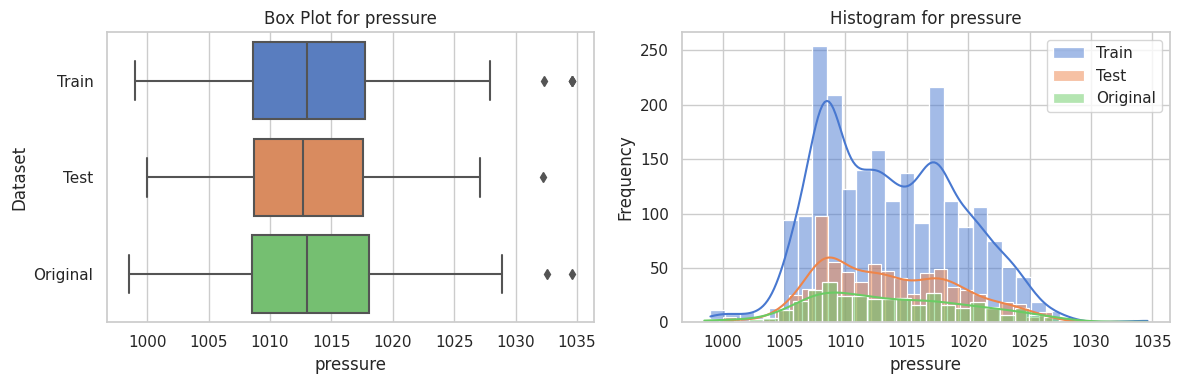

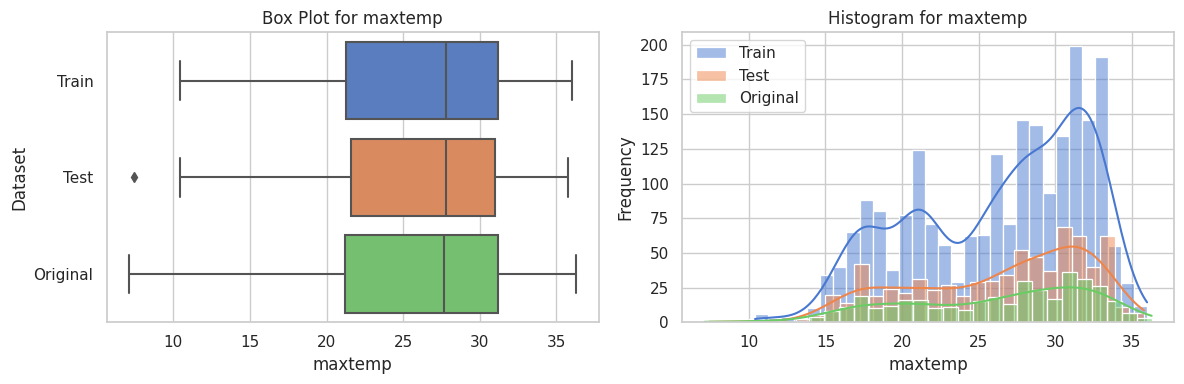

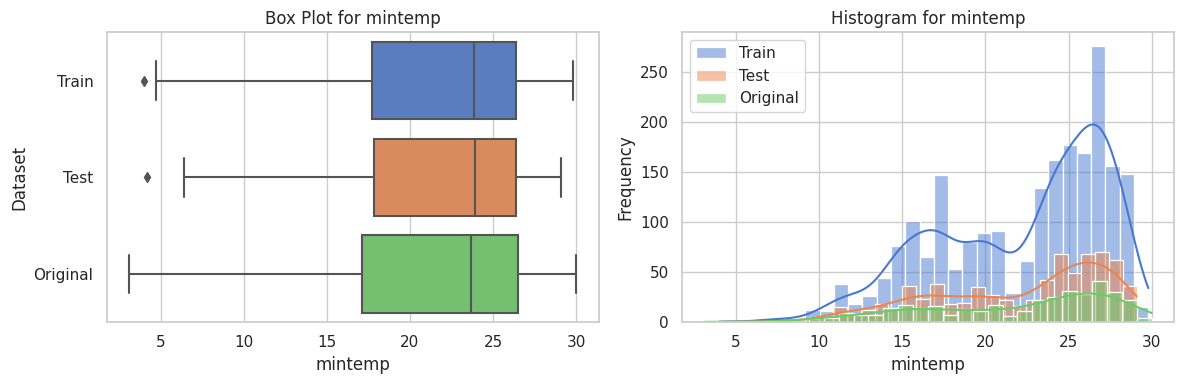

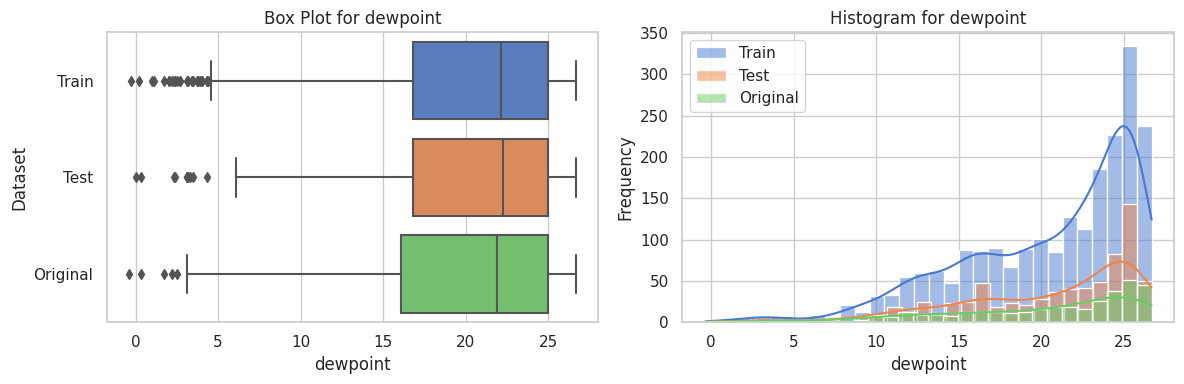

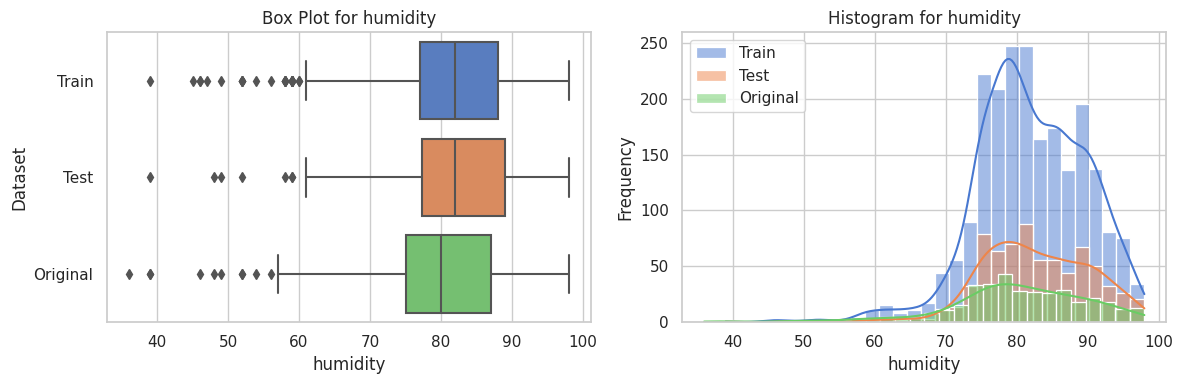

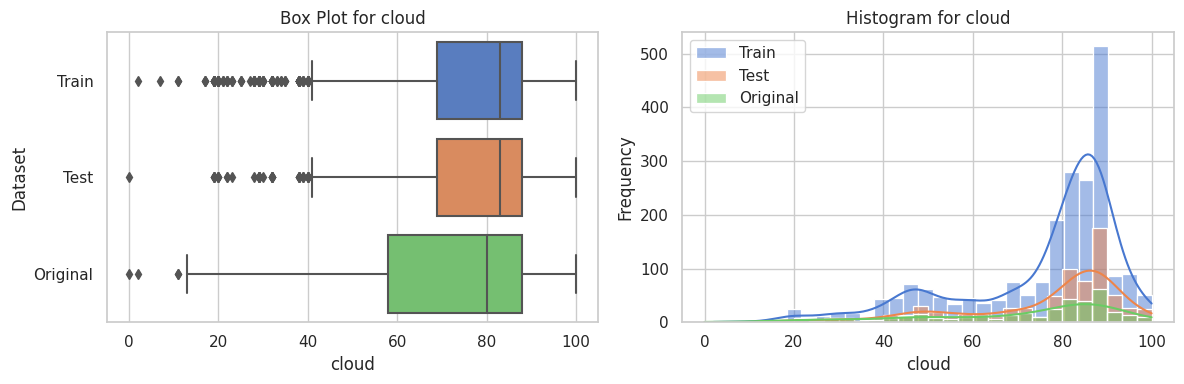

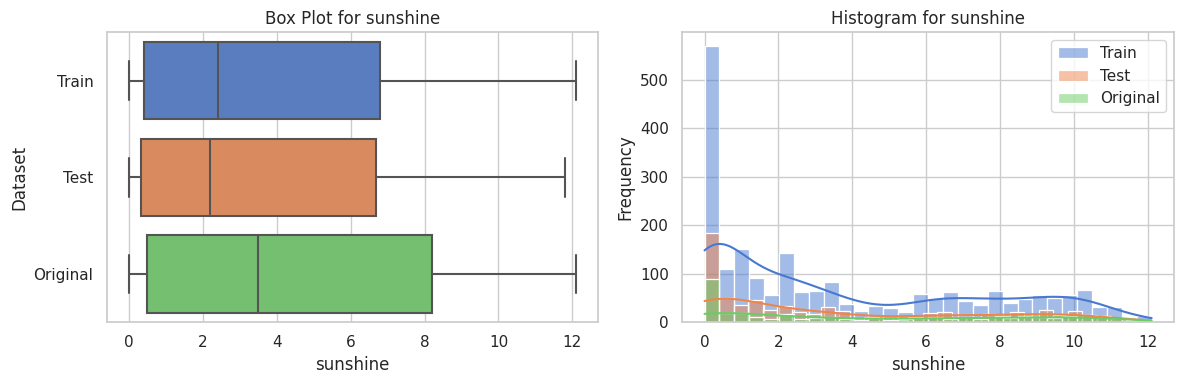

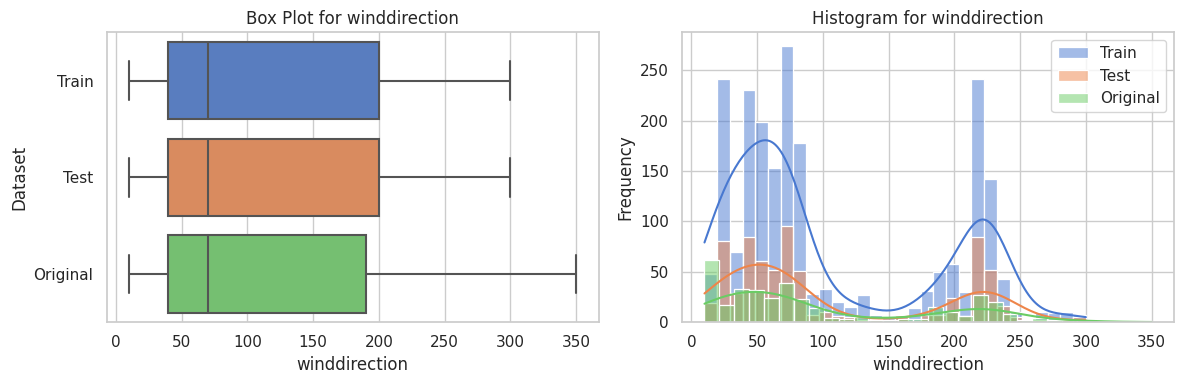

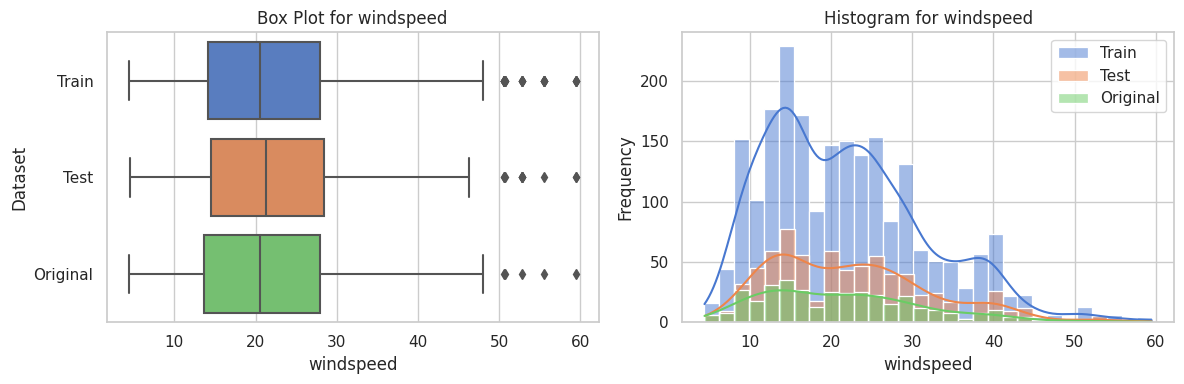

In [14]:
train_data['Dataset'] = 'Train'
test_data['Dataset'] = 'Test'
original_data['Dataset'] = 'Original'

numerical_variables = ['winddirection', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 

variables = [col for col in train_data.columns if col in numerical_variables]

def create_variable_plots(variable):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=pd.concat([train_data, test_data,original_data.dropna()]), x=variable, y='Dataset')
    plt.xlabel(variable)
    plt.title(f"Box Plot for {variable}")

    # Histograms
    plt.subplot(1, 2, 2)
    sns.histplot(data=train_data, x=variable, kde=True, bins=30, label="Train")
    sns.histplot(data=test_data, x=variable, kde=True, bins=30, label="Test")
    sns.histplot(data=original_data.dropna(), x=variable, kde=True, bins=30, label="Original")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {variable}")
    plt.legend()

    plt.tight_layout()
    plt.show()

for variable in variables:
    create_variable_plots(variable)

# Drop the 'Dataset' column after analysis
train_data.drop('Dataset', axis=1, inplace=True)
test_data.drop('Dataset', axis=1, inplace=True)
original_data.drop('Dataset', axis=1, inplace=True)

## **Box Plot and Histogram Key Observations**  
